# Histimator: Quick Tour

This notebook is a fast walk through the Histimator API. Every module is
exercised in a single worked example with no extended theory. If you want
to understand *why* these tools work the way they do, the subsequent
notebooks (01 through 10) follow a structured lecture sequence.

**What we will do here:** build a two-bin signal-plus-background model
with one shape systematic, fit it to pseudo-data, compute a discovery
significance and an upper limit, then run diagnostics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 12, "figure.facecolor": "white"})

from histimator import Parameter, Histogram, Sample, Channel, Model
from histimator.interpolation import InterpolationCode, interpolate
from histimator.likelihood import BinnedNLL, fit
from histimator.inference import profile_likelihood_ratio, upper_limit, discovery_significance
from histimator.test_statistics import compute_q0, compute_qmu, compute_qtilde_mu
from histimator.test_statistics import pvalue_q0, pvalues_qmu
from histimator.cls import build_asimov_model, cls_observed, cls_expected_band, upper_limit_cls
from histimator.toys import generate_toy_data, sample_nuisance_parameters, toy_cls
from histimator.scans import likelihood_scan_1d, scan_intervals, goodness_of_fit
from histimator.diagnostics import prefit_postfit_yields, nuisance_parameter_pulls, impacts

print("All imports successful.")

All imports successful.


## 1. Build a model

A Histimator model is assembled from the bottom up: Parameters define
degrees of freedom, Histograms hold binned data, Samples attach
modifiers to histogram templates, Channels collect samples with observed
data, and the Model sits at the top.

In [2]:
# Templates: 5-bin signal and background
edges = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0])
sig_template = Histogram([2, 8, 12, 6, 2], edges)
bkg_template = Histogram([40, 50, 45, 35, 30], edges)

# Signal sample with a free normalisation (the parameter of interest)
signal = Sample("signal", sig_template)
signal.add_normfactor("mu", nominal=1.0, bounds=(0.0, 10.0))

# Background sample with a shape systematic
bkg_down = Histogram([38, 46, 44, 37, 32], edges)
bkg_up   = Histogram([42, 54, 46, 33, 28], edges)
background = Sample("background", bkg_template)
background.add_histosys("bkg_shape", lo_hist=bkg_down, hi_hist=bkg_up)

# Assemble channel with pseudo-data (signal injected at mu=1.3)
np.random.seed(42)
true_mu = 1.3
expected = true_mu * sig_template.values + bkg_template.values
data = np.random.poisson(expected.astype(int))

sr = Channel("SR")
sr.add_sample(signal)
sr.add_sample(background)
sr.set_data(data)

model = Model("demo")
model.add_channel(sr)
print(model)

Model('demo', channels=['SR'], parameters=['mu', 'bkg_shape'])


## 2. Fit the model

In [3]:
result = fit(model)
print(f"Converged: {result.valid}")
for name in model.parameter_names:
    print(f"  {name:>12s} = {result.bestfit[name]:+.4f} +/- {result.errors[name]:.4f}")

Converged: True
            mu = +1.1894 +/- 0.5037
     bkg_shape = -0.1583 +/- 1.1269


## 3. Profile likelihood ratio and discovery significance

In [4]:
z, p = discovery_significance(model, "mu")
print(f"Discovery significance: Z = {z:.2f} sigma, p-value = {p:.4f}")

Discovery significance: Z = 3.56 sigma, p-value = 0.0002


## 4. Upper limit (profile likelihood inversion)

In [5]:
ul = upper_limit(model, "mu", cl=0.95)
print(f"95% CL upper limit on mu: {ul:.3f}")

95% CL upper limit on mu: 1.911


## 5. CLs limit with Brazil band

In [6]:
obs_limit, exp_band = upper_limit_cls(model, "mu")
print(f"Observed CLs limit: {obs_limit:.3f}")
print(f"Expected: {exp_band['median']:.3f} "
      f"[{exp_band['-1sig']:.3f}, {exp_band['+1sig']:.3f}] "
      f"({exp_band['-2sig']:.3f}, {exp_band['+2sig']:.3f})")

Observed CLs limit: 1.927
Expected: 0.880 [0.625, 1.251] (0.460, 1.720)


## 6. CCGV test statistics

In [7]:
q0, mu_hat = compute_q0(model, "mu")
p0 = pvalue_q0(q0)
print(f"q0 = {q0:.3f}, mu_hat = {mu_hat:.3f}, p0 = {p0:.4f}")

qmu, _ = compute_qmu(model, "mu", mu_test=2.0)
qtilde, _ = compute_qtilde_mu(model, "mu", mu_test=2.0)
print(f"qmu(2.0)     = {qmu:.3f}")
print(f"qtilde(2.0)  = {qtilde:.3f}")

q0 = 6.191, mu_hat = 1.109, p0 = 0.0064
qmu(2.0)     = 3.202
qtilde(2.0)  = 3.202


## 7. Likelihood scan

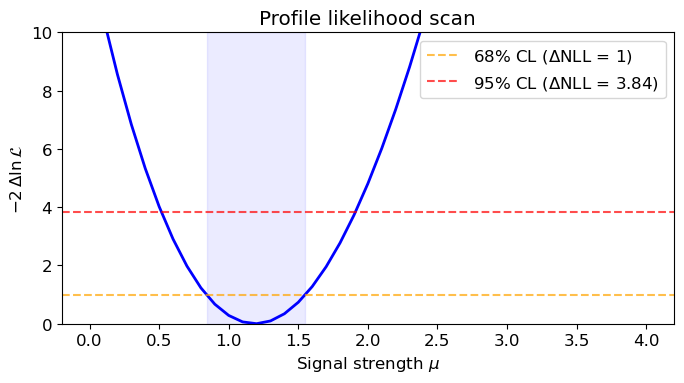

68% interval: [0.841, 1.549]


In [8]:
mu_vals, delta_nll = likelihood_scan_1d(model, "mu", bounds=(0.0, 4.0), n_points=41)
lo68, hi68 = scan_intervals(mu_vals, delta_nll, level=1.0)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(mu_vals, delta_nll, "b-", linewidth=2)
ax.axhline(1.0, color="orange", ls="--", alpha=0.7, label=r"68% CL ($\Delta$NLL = 1)")
ax.axhline(3.84, color="red", ls="--", alpha=0.7, label=r"95% CL ($\Delta$NLL = 3.84)")
ax.axvspan(lo68, hi68, color="blue", alpha=0.08)
ax.set_xlabel(r"Signal strength $\mu$")
ax.set_ylabel(r"$-2\,\Delta\ln\mathcal{L}$")
ax.set_title("Profile likelihood scan")
ax.set_ylim(0, 10)
ax.legend()
plt.tight_layout()
plt.show()
print(f"68% interval: [{lo68:.3f}, {hi68:.3f}]")

## 8. Goodness of fit

In [9]:
chi2, ndof, p_gof = goodness_of_fit(model)
print(f"GoF chi2 = {chi2:.2f}, ndof = {ndof}, p-value = {p_gof:.3f}")

GoF chi2 = 2.83, ndof = 3, p-value = 0.419


## 9. Diagnostics: pulls and impacts

In [10]:
pulls = nuisance_parameter_pulls(model)
for name, info in pulls.items():
    print(f"  {name:>15s}: pull = {info['pull']:+.3f}, "
          f"constraint = {info['constraint']:.3f}")

        bkg_shape: pull = -0.158, constraint = 1.127


In [11]:
impact_list = impacts(model, "mu")
for entry in impact_list[:5]:
    print(f"  {entry['name']:>15s}: "
          f"up = {entry['impact_up']:+.4f}, "
          f"down = {entry['impact_down']:+.4f}")

        bkg_shape: up = -0.0988, down = +0.1152


## 10. Toy-based inference

In [12]:
rng = np.random.default_rng(99)
toy_data = generate_toy_data(model, model.nominal_values(), rng)
print(f"Toy data (first channel): {toy_data[:5]}")

cls_toy = toy_cls(model, "mu", mu_test=2.0, n_toys=200, seed=7)
print(f"Toy-based CLs at mu=2.0: {cls_toy:.3f}")

Toy data (first channel): [42. 61. 52. 40. 42.]
Toy-based CLs at mu=2.0: 0.030


## 11. Pre-fit / post-fit yields

/var/folders/3w/jcz46dj964526sk_kgkg8p0r0000gn/T/ipykernel_12228/1307423579.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


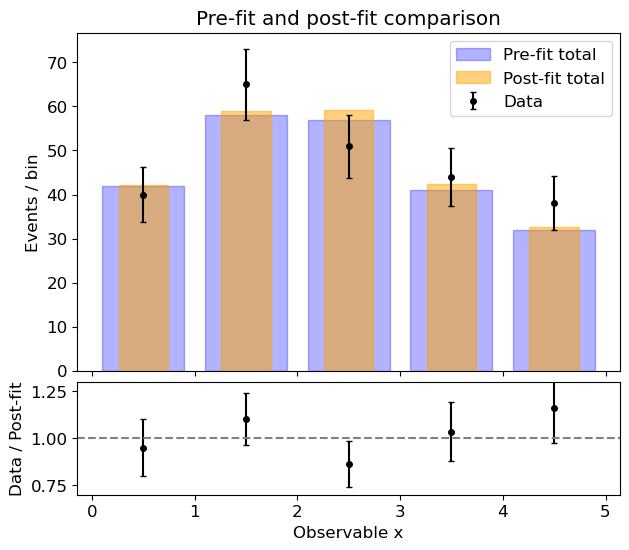

In [13]:
yields = prefit_postfit_yields(model)
ch = yields["SR"]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 6), height_ratios=[3, 1],
                                sharex=True, gridspec_kw={"hspace": 0.05})
centres = sig_template.centres
width = sig_template.widths[0] * 0.8

ax1.bar(centres, ch["prefit"]["total"], width=width, alpha=0.3,
        color="blue", edgecolor="blue", label="Pre-fit total")
ax1.bar(centres, ch["postfit"]["total"], width=width*0.6, alpha=0.5,
        color="orange", edgecolor="orange", label="Post-fit total")
ax1.errorbar(centres, ch["data"], yerr=np.sqrt(ch["data"]),
             fmt="ko", ms=4, capsize=2, label="Data")
ax1.set_ylabel("Events / bin")
ax1.legend()
ax1.set_title("Pre-fit and post-fit comparison")

ratio = ch["data"] / ch["postfit"]["total"]
ax2.errorbar(centres, ratio, yerr=np.sqrt(ch["data"]) / ch["postfit"]["total"],
             fmt="ko", ms=4, capsize=2)
ax2.axhline(1, color="gray", ls="--")
ax2.set_ylabel("Data / Post-fit")
ax2.set_xlabel("Observable x")
ax2.set_ylim(0.7, 1.3)
plt.tight_layout()
plt.show()

## Summary

This notebook touched every module in Histimator. The following notebooks
develop the theory and practice behind each of these steps in the order
that graduate-level HEP statistics courses teach them:

**01** Probability and the likelihood function.
**02** Building models from histogram templates.
**03** Interpolation schemes and modifier types.
**04** Maximum likelihood fitting.
**05** Hypothesis testing and test statistics.
**06** Upper limits and the CLs method.
**07** Toy-based inference.
**08** Likelihood scans and goodness of fit.
**09** Fit diagnostics: pulls, impacts, yields.
**10** Full analysis walkthrough (capstone).